# SIMWE, Part 1

## Part 1.1: Getting Started

### Start GRASS GIS

In [1]:
import subprocess
import sys
import numpy as np

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True, shell=False).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("./data/simwe/");

### Overview of Data and Study Area

Set the computational region to a small agricultural watershed:

In [2]:
!g.region region=e023 -p

projection: 99 (NAD83(HARN) / North Carolina)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      131300
south:      127522
west:       703265
east:       707263
nsres:      1
ewres:      1
rows:       3778
cols:       3998
cells:      15104444


Let's gather some quick information about our study area.

Before we start our analysis, let's also quick visualize our data.

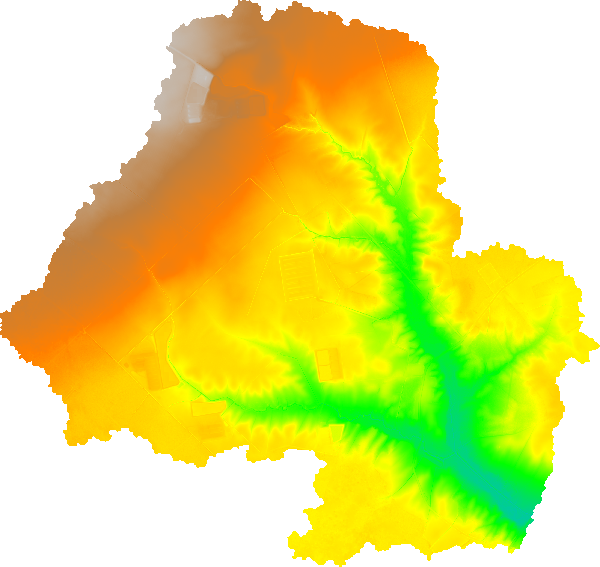

In [3]:
img=gj.Map(use_region=True)
img.d_rast(map="be_dem")
img.show()

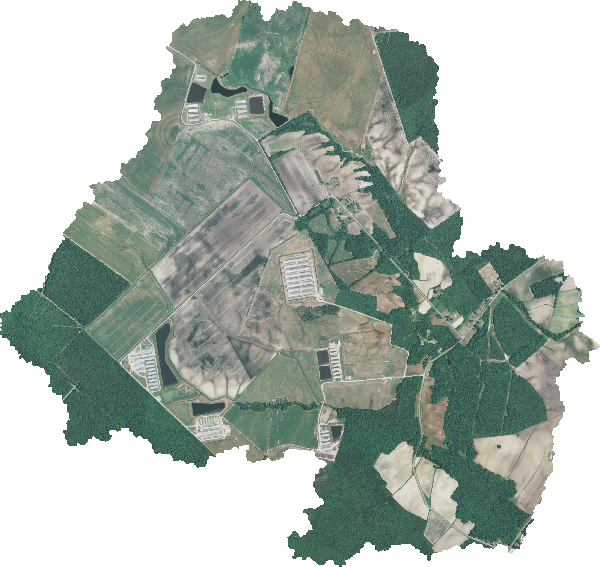

In [4]:
img=gj.Map(use_region=True)
img.d_rgb(red="naip_20140523.1", green="naip_20140523.2", blue="naip_20140523.3")
img.show()

## Part 1.2: Vegetated Swales and Their Impacts

Riparian buffers and vegetated swales impact flooding events in several ways. Let's imagine we are a drop of rain falling from the sky onto a buffer. First, we will probably come into contact with some vegetation: leaves and branch will likely intercept our fall to the ground. In fact, probably around 20% of rain drops will be caught be the canopy ([M. J. Gavazzi et al., 2016](https://www.srs.fs.usda.gov/pubs/ja/2016/ja_2016_mcnulty_003.pdf)). If we fall past the vegetation and hit the ground, we either infiltrate into the soil, or, if it's saturated or the rainfall rate is higher than infiltration rate, flow over the surface. The soil in vegetated areas is much more permeable than compacted surfaces like yards or agricultural fields and impervious surfaces like pavement so there's a good chance we'll infiltrate into the soil here since in the NC Coastal Plain, soil infiltration rates are between 13–28 cm/h ([Markewich et al., 1990](https://www.sciencedirect.com/science/article/pii/0169555X9090015I)). Finally, if we do end up flowing over the surface, the rough leaflitter, roots, sticks and ground vegetation will slow our velocity. Taken together, these effects (1) reduce the amount of overland water flow and (2) slow the velocity of overland water flow both of which reduce flooding. 

We're going to explore these impacts by simulating a flood event with several different swale sizes (none, 15m and 30m) and plot the hydrograph at the outflow of our watershed. 

First, let's look at the exisiting land cover in our study area.

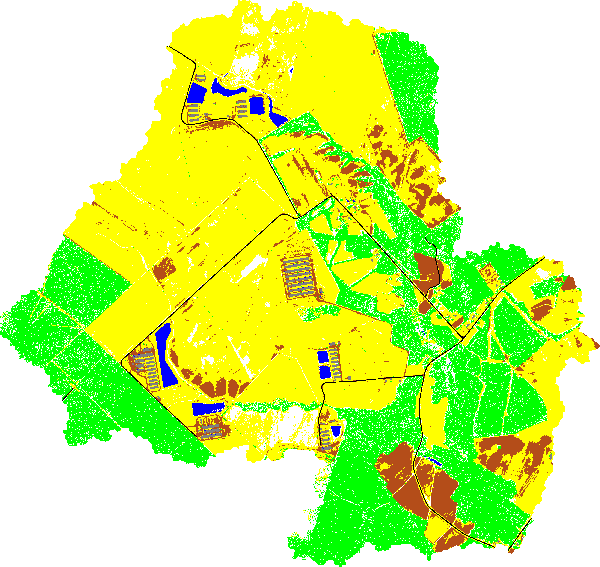

In [5]:
img=gj.Map(use_region=True)
img.d_rast(map="landcover")
img.show()

It has some holes in it so we will fill them in.

W-E size of neighborhood is 101 cells.
S-N size of neighborhood is 101 cells.
Input data range is 1.000000 to 6.000000.
Input data type is 'integer' (4 bytes) and output data type is 'integer' (4
bytes).
Minimal estimated memory usage is 4.180 MB.
Interpolating:
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.fill.stats complete. Processing time was 0h10m3s.
Color table for raster map <landcover_filled> set to 'landcover'


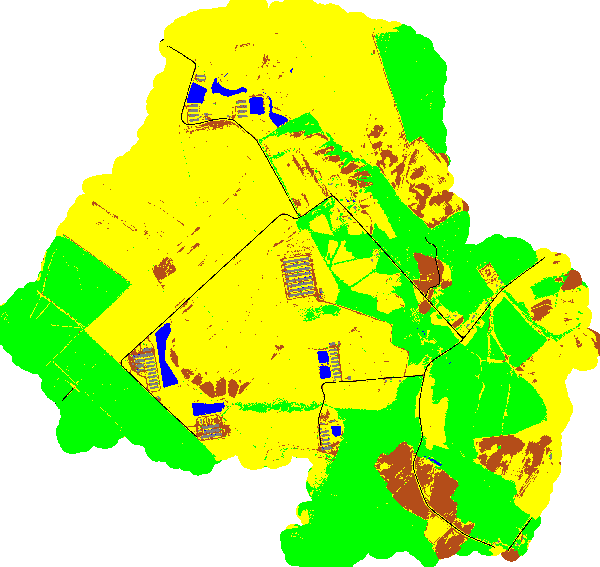

In [6]:
!r.fill.stats input=landcover output=landcover_filled dist=50 -m mode=mode -k
!r.colors map="landcover_filled" raster="landcover"

img=gj.Map(use_region=True)
img.d_rast(map="landcover_filled")
img.show()

### Identify Target Swale Areas

We'll use a small subset of the area to implement swales. In this area, there is a swine lagoon sprayfield with channels that lead in to the streams. Implementing vegetated swales here could prevent some of the nutrients and fecal matter in the spray from reaching downstream waterbodies.

In [9]:
!g.region region=buffer_area
!v.in.region output=target_area

Building topology for vector map <target_area@simwe>...
Registering primitives...
Building areas...
   0 100
Attaching islands...
   0 100
Attaching centroids...
   0 100


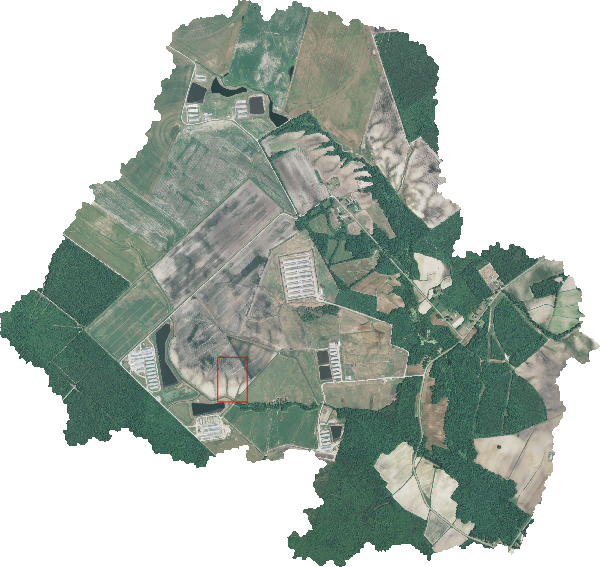

In [13]:
img=gj.Map()
img.d_rgb(red="naip_20140523.1", green="naip_20140523.2", blue="naip_20140523.3")
img.d_vect(map="target_area", fill_color="none", color="red")
img.show()

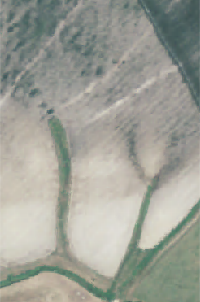

In [14]:
img = gj.Map(use_region=True, width=200)
img.d_rgb(red="naip_20140523.1", green="naip_20140523.2", blue="naip_20140523.3")
img.show()

We'll make our vegetated buffers around the channels visible in the NAIP imagery above. First, we'll make a flowline for the channel and then we create a buffer around it.

In [15]:
!r.watershed elevation=be_dem accumulation=accum

SECTION 1a (of 4): Initiating Memory.
SECTION 1b (of 4): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3a: Accumulating Surface Flow with MFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 3b: Adjusting drainage directions.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Closing Maps.


   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Raster map <buffer_streams> - 297 rows X 197 columns
Bounding box: l = 51, r = 153, t = 118, b = 286
Pass number 1
Deleted 13 pixels
Pass number 2
Deleted 0 pixels
Thinning completed successfully.
Output map 297 rows X 197 columns
Window 297 rows X 197 columns
Default driver / database set to:
driver: sqlite
database: $GISDBASE/$LOCATION_NAME/$MAPSET/sqlite/sqlite.db
Extracting lines...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
 100
Building topology for vector map <streams@simwe>...
Registering primitives...
r.to.vect complete.


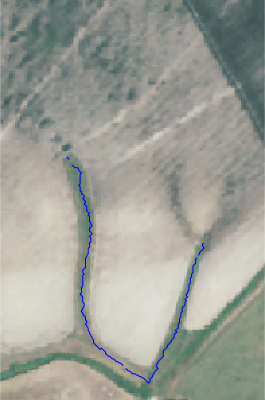

In [16]:
!r.mapcalc "buffer_streams = if(abs(accum) > 5000 && abs(accum) < 21000, 1, null())"
!r.thin buffer_streams output=streams_t
!r.to.vect -s streams_t out=streams type=line

img=gj.Map(use_region=True)
img.d_rgb(red="naip_20140523.1", green="naip_20140523.2", blue="naip_20140523.3")
img.d_vect(map="streams", color="blue")
img.show()

### Create Swales

Now, we're ready to create our swales. As decided earlier, we'll use two sizes: 15m and 30m, a larger width that may have a great impact on discharge.

In [17]:
# Zoom out a little more
!g.region region=TL1

In [18]:
gs.run_command("v.buffer", input="streams", output="buffer15", type="line", distance=15)
gs.run_command("v.buffer", input="streams", output="buffer30", type="line", distance=30)

View our new buffers on the land cover data.

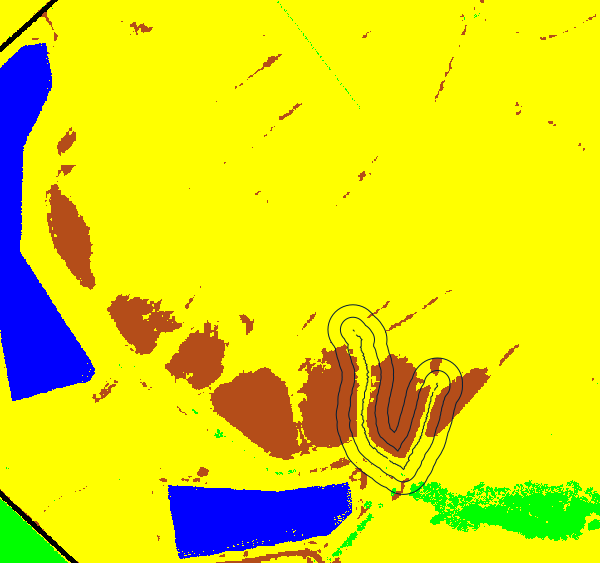

In [19]:
img=gj.Map(use_region=True)
img.d_rast(map="landcover_filled")
img.d_vect(map="streams")
img.d_vect(map="buffer15", fill_color="none")
img.d_vect(map="buffer30", fill_color="none")
img.show()

Add these swales to the landcover rasters.

In [28]:
# make landcover map with 15 meter buffers
gs.run_command("v.to.rast", input="buffer15", output="buffer15", use="cat")
gs.mapcalc("lc_buff15 = if(isnull(buffer15), landcover_filled, 2)")
gs.run_command("r.colors", map="lc_buff15", raster="landcover_filled")

In [29]:
# make landcover map with 30 meter buffers
gs.run_command("v.to.rast", input="buffer30", output="buffer30", use="cat")
gs.mapcalc("lc_buff30 = if(isnull(buffer30), landcover_filled, 2)")
gs.run_command("r.colors", map="lc_buff30", raster="landcover_filled")

Take a quick peak at the updated landcover raster with a 30 meter buffer

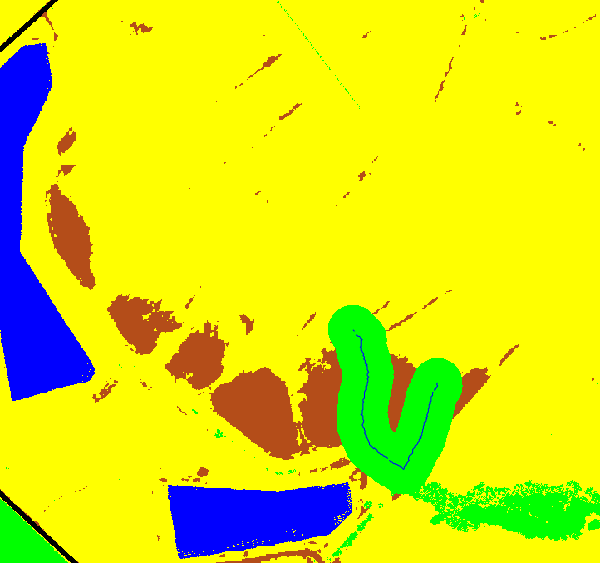

In [30]:
img=gj.Map(use_region=True)
img.d_rast(map="lc_buff30")
img.d_vect(map="streams", color="blue")
img.show()

## Part 1.3: Create a Storm

Now, let's imagine our storm that we are going to test our buffers on. Check out [these visuals](https://www.weather.gov/lox/rainrate) from the National Weather Service to get an idea of rainfall rates. Just because it's most exciting, say our storm has the highest rainfall rate shown on their website: 1.5 inches per hour (or about 40 mm/hr). That's a rainfall rate that could reasonably occur during an intense thunderstorm in North Carolina. The rainfall rate will be constant over our study area.

In [31]:
rainfall_rate = 40 # mm/hr

gs.mapcalc("rainfall={}".format(rainfall_rate))

## Part 1.4: Vegetation Interception and Infiltration

Recall from above our imaginary journey as a raindrop: in the riparian buffer, we are either (1) intercepted by the vegetation, (2) infiltrated into the soil or (3) travel as overland flow. We are going to use the [r.sim.water](https://grass.osgeo.org/grass82/manuals/r.sim.water.html) module to simulate overland flow. 

The infiltration parameter of r.sim.water accounts for particles of overland flow that are infiltrated, as shown by the "infiltration (of overland flow)" in diagram above (i.e. a raindrop that fell on some nearby pavement, flowed into our riparian buffer where it infiltrated into the soil). Before we can run r.sim.water, we need to account for vegetation interception and immediate infiltration, both of which are a function of land cover (see diagram above).

Because vegetation interception and infiltration are a function of land cover, we will reclassify our landcover map to corresponding values of interception and infiltration. For each category of land cover, we assign a value for interception and infiltration. These pairs are found in [land_to_intercept.txt](./land_to_intercept.txt) and [land_to_infil.txt](./land_to_infil.txt).

In [32]:
# No Buffer
gs.run_command("r.recode", input="landcover_filled", output="infiltration", rules="land_to_infil.txt") #mm/hr
gs.run_command("r.recode", input="landcover_filled", output="intercept", rules="land_to_intercept.txt") #percentage

# 15m Buffer
gs.run_command("r.recode", input="lc_buff15", output="infiltration15", rules="land_to_infil.txt") #mm/hr
gs.run_command("r.recode", input="lc_buff15", output="intercept15", rules="land_to_intercept.txt") #percentage

# 30m Buffer
gs.run_command("r.recode", input="lc_buff30", output="infiltration30", rules="land_to_infil.txt") #mm/hr
gs.run_command("r.recode", input="lc_buff30", output="intercept30", rules="land_to_intercept.txt") #percentage

Now, we can subtract intercepted and infiltrated rain from our rainfall raster to get the excess rainfall. The incepted rain is a percentage of the total rain so our equation will be:

$$ i_e = i(1-r) - g $$

where:

$i_e$ is the excess rainfall rate (mm/hr)

$i$ is the rainfall rate (mm/hr)

$r$ is the percentage of rain that is captured by the vegetation

$g$ is the rate of infiltration into the soil (mm/hr)

In [33]:
# Create rainfall excess map
gs.mapcalc("rainfall_excess=rainfall*(1-intercept)-infiltration")
gs.mapcalc("rainfall_excess15=rainfall*(1-intercept15)-infiltration15")
gs.mapcalc("rainfall_excess30=rainfall*(1-intercept30)-infiltration30")

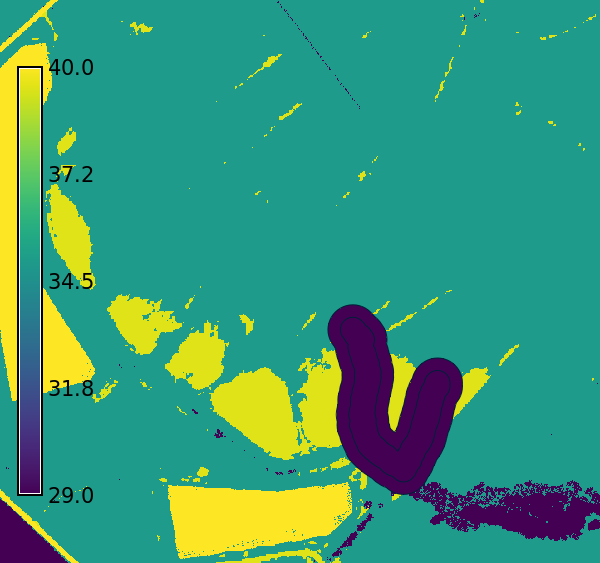

In [34]:
excess=gj.Map(use_region=True)
excess.d_rast(map="rainfall_excess30")
# excess.d_vect(map="marsh_swamp_stream")
excess.d_vect(map="buffer15", fill_color="none")
excess.d_vect(map="buffer30", fill_color="none")
excess.d_legend(raster="rainfall_excess30")
excess.show()

### _Now that we have accounted for vegetation interception and initial infiltration to create a rainfall excess map, we're ready to simulate surface flow._ 

### _Continue to Part 2!_